# Planify - Graph Neural Network

### Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
    <ul>
        <li><a href="#Imports">Imports</a></li>
        <li><a href="#func">Functions used</a></li>
    </ul>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#model">GNN Model</a></li>
    <ul>
        <li><a href="#dataLoader">Data Loader</a></li>
        <li><a href="#archi">Architecture</a></li>
        <li><a href="#train">Training</a></li> 
        <li><a href="#eval">Evaluation</a></li>
    </ul>
</ul>

<a id='intro'></a>
## Introduction

> This notebook getting garphs in the Networkx format from the `Creating Graphs` notebook. And its main goal is to make the GNN model.

In [3]:
# Used for vsCode only to show tqdm process
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

<a id='Imports'></a>
### Imports

In [4]:
# Only for kaggle
# !pip install torch_geometric

In [5]:
# Not included packages in kaggle

# Install torch_geometric
# !pip install /kaggle/input/torch-geometric/torch_sparse-0.6.16-cp37-cp37m-linux_x86_64.whl -q
# !pip install /kaggle/input/torch-geometric/torch_scatter-2.1.0-cp37-cp37m-linux_x86_64.whl -q

# # # library for getting distinct colores
!pip install distinctipy -q

In [1]:
# for data wrangling
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import distinctipy
import random
from torch_geometric.utils import from_networkx

# to show advance in for loops
from tqdm import tqdm

# Using pytorch geometric
import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data, Batch
from torch.utils.data import Dataset
import torch_geometric.transforms as T


# For the GNN model
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool, global_max_pool


# for my pc [linux]
# url = '/media/mo/DATA/Grad/Planify_Dataset/Graph/Planify_Graphs.pkl'

# for my pc [windows]
url = "D:\Grad\Planify_Dataset\Graph\Planify_Graphs.pkl"

# for kaggle
# url = '/kaggle/input/planify-graphs/Planify_Graphs.pkl'

<a id='func'></a>
### Functions used

In [2]:
geoms_columns = ['inner', 'living', 'master', 'kitchen', 'bathroom', 'dining', 'child', 'study',
                   'second_room', 'guest', 'balcony', 'storage', 'wall-in',
                    'outer_wall', 'front', 'inner_wall', 'interior',
                   'front_door', 'outer_wall', 'entrance']

N = len(geoms_columns)
colors = (np.array(distinctipy.get_colors(N)) * 255).astype(np.uint8)
room_color = {room_name: colors[i] for i, room_name in enumerate(geoms_columns)}

In [3]:
def draw_graph(G):
    #  nodes positions for drawing, note that we invert the y pos
    pos = {node: (G.nodes[node]['actualCentroid_x'], -G.nodes[node]['actualCentroid_y']) for node in G.nodes}
    
    scales = [G.nodes[node]['roomSize'] * 10000 for node in G] 
    colormap = [room_color[G.nodes[node]['roomType_name']]/255 for node in G]
    
    nx.draw(G, pos=pos, node_size=scales, node_color=colormap, with_labels=True, font_size=12)
    
    # Drawing the graph inside a good boundary.
    x_coords  = [pos[node][0] for node in pos]
    y_coords  = [pos[node][1] for node in pos]
    threshold = max(scales) / 100
    
    plt.xlim(min(x_coords) - threshold, max(x_coords) + threshold)
    plt.ylim(min(y_coords) - threshold, max(y_coords) + threshold)


def collate_fn(graphs_list):
    batch = Batch.from_data_list([Data.from_(g) for g in graphs_list])
    return batch

<a id='wrangling'></a>
## Data wrangling


Graph with 7 nodes and 9 edges


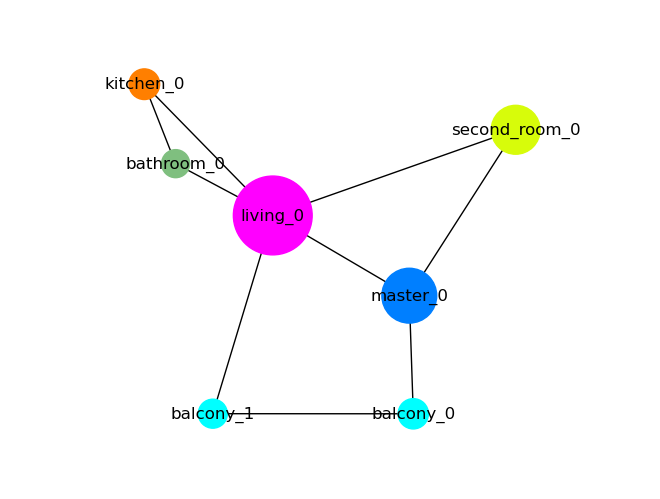

In [4]:
with open(url, 'rb') as f:
    Graphs = pickle.load(f)
    
G = Graphs[1911]
print(G)
draw_graph(G)

In [5]:
features = ['roomType_embd', 'actualCentroid_x', 'actualCentroid_y']

In [6]:
# Converting networkx graphs to pytorchGeo graphs
Graphs_pyTorch = []
for G in tqdm(Graphs):
    G_new = from_networkx(G, group_node_attrs=features, group_edge_attrs=['dist'])
    # Normalizing feature matrix (x)
    # G_new = T.NormalizeFeatures()(G_new)
    
    Graphs_pyTorch.append(G_new)

Graphs_pyTorch[0]

100%|████████████████████████████████| 80788/80788 [00:41<00:00, 1937.12it/s]


Data(edge_index=[2, 12], roomType_name=[5], rec_w=[5], rec_h=[5], roomSize=[5], x=[5, 3], edge_attr=[12, 1])

> There are many types of `rooms` but we will give them a defualt number = 1.
> So, also we will decrease the embedings to be between 0:6

In [7]:
print(f'Befor: G_1 embedings are: {Graphs_pyTorch[1].x}')
for G in tqdm(Graphs_pyTorch, total=len(Graphs_pyTorch)):
    for j ,value in enumerate(G.x):
        type_ = int(value[0].item())
        
        if type_ in [1, 4, 5, 6, 7, 8]:
            G.x[j][0] = 1
        
        # making all labels from 0 to 6 only to help one_hotting
        elif type_ == 9:
            G.x[j][0] = 4
        elif type_ == 10:
            G.x[j][0] = 5
        elif type_ == 11:
            G.x[j][0] = 6

    # G = T.NormalizeFeatures()(G)
    
print(f'After: G_1 embedings are: {Graphs_pyTorch[1].x}')

Befor: G_1 embedings are: tensor([[  0.0000, 126.9323, 119.2773],
        [  1.0000, 116.0000, 197.5000],
        [  2.0000, 179.0000,  42.0000],
        [  3.0000, 206.9337,  78.3202],
        [  7.0000,  80.5000,  75.5000],
        [  7.0000, 127.6623,  55.4979],
        [  9.0000,  44.5000, 134.5000],
        [ 10.0000, 138.5000,  92.5000]])


100%|███████████████████████████████| 80788/80788 [00:05<00:00, 15623.69it/s]

After: G_1 embedings are: tensor([[  0.0000, 126.9323, 119.2773],
        [  1.0000, 116.0000, 197.5000],
        [  2.0000, 179.0000,  42.0000],
        [  3.0000, 206.9337,  78.3202],
        [  1.0000,  80.5000,  75.5000],
        [  1.0000, 127.6623,  55.4979],
        [  4.0000,  44.5000, 134.5000],
        [  5.0000, 138.5000,  92.5000]])


In [212]:
for G in Graphs_pyTorch:
    x = G.x
    min_vals = torch.min(x, dim=0)[0]
    max_vals = torch.max(x, dim=0)[0]
    x_normalized = (x - x.min(dim=0).values) / (x.max(dim=0).values - x.min(dim=0).values)
    G.x = x_normalized

> If we need to creat graphs with padding by the maximum number of nodes.

In [13]:
# # but we need to do some padding to our graphs to be all of the same number of nodes.
# padded_graphs = []
# for G in Graphs_pyTorch:
#     x          = G.x
#     y          = G.roomType_embd
#     edge_index = G.edge_index
#     edge_attr  = G.edge_attr
    
#     nu_nodes = x.shape[0]

#     padded_x = torch.nn.functional.pad(x, pad=(0, 0, 0, 8 - nu_nodes), mode='constant', value=0)
#     padded_y = torch.nn.functional.pad(y, pad=(0, 8 - nu_nodes), mode='constant', value=0)
#     train_mask   = torch.ones(nu_nodes)
#     train_mask   = torch.nn.functional.pad(train_mask, pad=(0, 8 - nu_nodes), mode='constant', value=0).to(bool)

#     data = Data(x = padded_x, y = padded_y, edge_index= G.edge_index, edge_attr = G.edge_attr, train_mask=train_mask)

#     padded_graphs.append(data)

# padded_graphs[0]

<a id='model'></a>
## GNN Model

<a id='dataLoader'></a>
### Data Loader

In [106]:
class Planify_Dataset(Dataset):
    def __init__(self, data):
        self.Graphs = data
    
    def __len__(self):
        return len(self.Graphs)

    def __getitem__(self, index):
        G = self.Graphs[index].clone().to(device)
        # shuffling nodes inside the same graph
        permutation = torch.randperm(G.num_nodes).to(device)
        
        G.x = G.x[permutation]
        G.edge_index = permutation[G.edge_index]
        G.rec_w = G.rec_w[permutation]
        G.rec_h = G.rec_h[permutation]
        # padded_x = torch.nn.functional.pad(x, pad=(0, 0, 0, 8 - nu_nodes), mode='constant', value=0)
        # padded_y = torch.nn.functional.pad(y, pad=(0, 8 - nu_nodes), mode='constant', value=0)
        return G

In [9]:
edge = int(len(Graphs_pyTorch) * 0.8)

In [107]:
# There is a problem here, the first graph has this problem on my device [windows]

batch_size = 128
train_dataset = Planify_Dataset(Graphs_pyTorch[:edge])
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

test_dataset = Planify_Dataset(Graphs_pyTorch[edge:])
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [108]:
# Saving model function
import os

# checkpoint_dir = '/kaggle/working/checkpoints'
# checkpoint_dir = '/media/mo/DATA/Grad/Planify_Dataset/Graph/checkpoints'
checkpoint_dir = "./checkpoints"

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    

def save_checkpoint(model, optimizer, epoch):
    checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch}.pt')
    # Saving model each 15 epochs
    if epoch % 20 == 0:
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch
        }, checkpoint_path)
        
        print('Model saved :)')

<a id='archi'></a>
### Architecture

In [109]:
from torch_geometric.nn import GlobalAttention

class GATNet(torch.nn.Module):
    def __init__(self, num_node_features):
        super(GATNet, self).__init__()
        self.conv1 = GATConv(num_node_features, 32, heads=8, dropout=0.2)
        self.conv2 = GATConv(32*8, 64, heads=8, dropout=0.2)
        self.lin1 = torch.nn.Linear(64*8, 32)
        self.lin2 = torch.nn.Linear(32, 2)

    def forward(self, x, edge_index, batch):
        if batch == None:
            batch = torch.zeros(G22.x.shape[0], dtype=torch.long)
        
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        # x = torch_geometric.nn.global_mean_pool(x, batch) # global mean pooling
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x

model = GATNet(3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# to monitor the loss & accuracy.
errors = []
acc = []

model

GATNet(
  (conv1): GATConv(3, 32, heads=8)
  (conv2): GATConv(256, 64, heads=8)
  (lin1): Linear(in_features=512, out_features=32, bias=True)
  (lin2): Linear(in_features=32, out_features=2, bias=True)
)

In [114]:
# Hyperparameters
learning_rate = 0.001
nu_epochs = 50

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.972)

# def scheduler(epoch, lr)
#     if epoch < 20:
#         return lr
#     else:
#         return lr * 0.99

<a id='train'></a>
### Training


In [115]:
def train(model, optimizer, criterion, train_loader):
    model.train()
    train_loss = 0.0
    for i, data in tqdm(enumerate(train_loader), desc='Planifying', total=len(train_loader)):
        optimizer.zero_grad()
        # Forward pass
        data = data.to(device)
        
        logits    = model(data.x, data.edge_index, data.batch)
        # computing loss through crossEntropy loss function
        targets = torch.cat((data.rec_w.unsqueeze(1), data.rec_h.unsqueeze(1)), dim=1)
        # print(logits.shape, targets.shape)
        loss = criterion(logits, targets)
        
        # Backward pass
        loss.backward()
        
        # Updating parameters
        optimizer.step()

        # Monitoring
        running_loss += loss.item()
        lr = optimizer.param_groups[0]['lr']
        
    return train_loss / len(train_loader)


def evaluate(model, criterion, loader):
    model.eval()
    loss = 0.0
    for data in test_loader:
        with torch.no_grad():
            out = model(data.x, data.edge_index, data.batch)
            targets = torch.cat((data.rec_w.unsqueeze(1), data.rec_h.unsqueeze(1)), dim=1)
            loss += criterion(out, targets).item() * data.num_graphs
    return loss / len(loader.dataset)

In [116]:
for epoch in range(nu_epochs):
    running_loss = 0.0
    train_acc    = 0.0
    for i, data in tqdm(enumerate(train_loader), desc='Planifying', total=len(train_loader)):
        optimizer.zero_grad()
        # Forward pass
        data = data.to(device)
        
        logits    = model(data.x, data.edge_index, data.batch)
        # computing loss through crossEntropy loss function
        targets = torch.cat((data.rec_w.unsqueeze(1), data.rec_h.unsqueeze(1)), dim=1)
        # print(logits.shape, targets.shape)
        loss = criterion(logits, targets)
        
        # Backward pass
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        # current_lr = optimizer.param_groups[0]['lr']
        # optimizer = torch.optim.Adam(model.parameters(), lr=scheduler(epoch, current_lr))
        
        # Monitoring
        running_loss += loss.item()
        # train_acc += (torch.argmax(logits, 1).flatten() == data.roomType_embd).type(torch.float).mean().item()
        lr = optimizer.param_groups[0]['lr']
    
    # model.regreetor.reset_parameters()
    
    print(targets[0, :])
    print(logits[0, :])
    
    errors.append(running_loss/batch_size)
    # acc.append(train_acc/batch_size)
    
    # Updating scheduler each 15 epochs.
    # scheduler.step()
    
    # Saving the model.
    save_checkpoint(model, optimizer, epoch)
    
    # Monitoring and printing.
    batch_size = len(train_loader)
    print(f'Epoch: {epoch + 1}/{nu_epochs} | lr: {lr} | avg_loss: {running_loss/batch_size:.5f}')

Planifying: 100%|██████████████████████████| 505/505 [00:47<00:00, 10.63it/s]


tensor([ 89., 100.], device='cuda:0')
tensor([68.6268, 75.2993], device='cuda:0', grad_fn=<SliceBackward0>)
Model saved :)
Epoch: 1/50 | lr: 0.001 | avg_loss: 700.69120


Planifying: 100%|██████████████████████████| 505/505 [00:47<00:00, 10.63it/s]


tensor([25., 31.], device='cuda:0')
tensor([39.6475, 39.8844], device='cuda:0', grad_fn=<SliceBackward0>)
Epoch: 2/50 | lr: 0.001 | avg_loss: 641.68033


Planifying: 100%|██████████████████████████| 505/505 [00:49<00:00, 10.17it/s]


tensor([41., 49.], device='cuda:0')
tensor([40.0513, 39.3453], device='cuda:0', grad_fn=<SliceBackward0>)
Epoch: 3/50 | lr: 0.001 | avg_loss: 571.85574


Planifying: 100%|██████████████████████████| 505/505 [00:48<00:00, 10.40it/s]


tensor([41., 49.], device='cuda:0')
tensor([43.4639, 40.8786], device='cuda:0', grad_fn=<SliceBackward0>)
Epoch: 4/50 | lr: 0.001 | avg_loss: 508.04237


Planifying: 100%|██████████████████████████| 505/505 [00:47<00:00, 10.54it/s]


tensor([23.,  4.], device='cuda:0')
tensor([50.3735, 43.8598], device='cuda:0', grad_fn=<SliceBackward0>)
Epoch: 5/50 | lr: 0.001 | avg_loss: 412.34775


Planifying: 100%|██████████████████████████| 505/505 [00:48<00:00, 10.47it/s]


tensor([41., 49.], device='cuda:0')
tensor([39.3699, 33.2874], device='cuda:0', grad_fn=<SliceBackward0>)
Epoch: 6/50 | lr: 0.001 | avg_loss: 359.61248


Planifying: 100%|██████████████████████████| 505/505 [00:49<00:00, 10.24it/s]


tensor([25., 31.], device='cuda:0')
tensor([44.3293, 28.8469], device='cuda:0', grad_fn=<SliceBackward0>)
Epoch: 7/50 | lr: 0.001 | avg_loss: 332.06949


Planifying: 100%|██████████████████████████| 505/505 [00:47<00:00, 10.72it/s]


tensor([41., 49.], device='cuda:0')
tensor([40.1669, 41.7617], device='cuda:0', grad_fn=<SliceBackward0>)
Epoch: 8/50 | lr: 0.001 | avg_loss: 319.70581


Planifying: 100%|██████████████████████████| 505/505 [00:48<00:00, 10.44it/s]


tensor([24., 25.], device='cuda:0')
tensor([39.0505, 31.6514], device='cuda:0', grad_fn=<SliceBackward0>)
Epoch: 9/50 | lr: 0.001 | avg_loss: 309.37649


Planifying: 100%|██████████████████████████| 505/505 [00:50<00:00,  9.99it/s]


tensor([24., 25.], device='cuda:0')
tensor([37.6684, 40.2655], device='cuda:0', grad_fn=<SliceBackward0>)
Epoch: 10/50 | lr: 0.001 | avg_loss: 299.72141


Planifying: 100%|██████████████████████████| 505/505 [00:48<00:00, 10.51it/s]


tensor([43., 54.], device='cuda:0')
tensor([39.0254, 40.0125], device='cuda:0', grad_fn=<SliceBackward0>)
Epoch: 11/50 | lr: 0.001 | avg_loss: 292.24333


Planifying: 100%|██████████████████████████| 505/505 [00:47<00:00, 10.68it/s]


tensor([ 89., 100.], device='cuda:0')
tensor([72.7853, 88.5041], device='cuda:0', grad_fn=<SliceBackward0>)
Epoch: 12/50 | lr: 0.001 | avg_loss: 283.75074


Planifying: 100%|██████████████████████████| 505/505 [00:46<00:00, 10.83it/s]


tensor([40., 54.], device='cuda:0')
tensor([48.8052, 57.0075], device='cuda:0', grad_fn=<SliceBackward0>)
Epoch: 13/50 | lr: 0.001 | avg_loss: 278.08671


Planifying: 100%|██████████████████████████| 505/505 [00:47<00:00, 10.65it/s]


tensor([43., 54.], device='cuda:0')
tensor([42.0688, 51.8144], device='cuda:0', grad_fn=<SliceBackward0>)
Epoch: 14/50 | lr: 0.001 | avg_loss: 268.28390


Planifying: 100%|██████████████████████████| 505/505 [00:47<00:00, 10.70it/s]


tensor([25., 31.], device='cuda:0')
tensor([35.6065, 29.2224], device='cuda:0', grad_fn=<SliceBackward0>)
Epoch: 15/50 | lr: 0.001 | avg_loss: 260.29759


Planifying: 100%|██████████████████████████| 505/505 [00:47<00:00, 10.69it/s]


tensor([41., 49.], device='cuda:0')
tensor([41.0782, 39.3802], device='cuda:0', grad_fn=<SliceBackward0>)
Epoch: 16/50 | lr: 0.001 | avg_loss: 250.51274


Planifying: 100%|██████████████████████████| 505/505 [00:54<00:00,  9.29it/s]


tensor([23.,  4.], device='cuda:0')
tensor([48.1839, 21.2276], device='cuda:0', grad_fn=<SliceBackward0>)
Epoch: 17/50 | lr: 0.001 | avg_loss: 247.19745


Planifying: 100%|██████████████████████████| 505/505 [00:51<00:00,  9.87it/s]


tensor([37., 13.], device='cuda:0')
tensor([42.9671, 26.7877], device='cuda:0', grad_fn=<SliceBackward0>)
Epoch: 18/50 | lr: 0.001 | avg_loss: 239.43638


Planifying: 100%|██████████████████████████| 505/505 [00:47<00:00, 10.72it/s]


tensor([23.,  4.], device='cuda:0')
tensor([37.4969, 22.1000], device='cuda:0', grad_fn=<SliceBackward0>)
Epoch: 19/50 | lr: 0.001 | avg_loss: 233.37678


Planifying: 100%|██████████████████████████| 505/505 [00:47<00:00, 10.69it/s]


tensor([41., 49.], device='cuda:0')
tensor([38.9587, 41.0810], device='cuda:0', grad_fn=<SliceBackward0>)
Epoch: 20/50 | lr: 0.001 | avg_loss: 230.68301


Planifying: 100%|██████████████████████████| 505/505 [00:47<00:00, 10.72it/s]


tensor([25., 31.], device='cuda:0')
tensor([38.3658, 29.2568], device='cuda:0', grad_fn=<SliceBackward0>)
Model saved :)
Epoch: 21/50 | lr: 0.001 | avg_loss: 228.11266


Planifying: 100%|██████████████████████████| 505/505 [00:46<00:00, 10.78it/s]


tensor([41., 49.], device='cuda:0')
tensor([37.2549, 48.8878], device='cuda:0', grad_fn=<SliceBackward0>)
Epoch: 22/50 | lr: 0.001 | avg_loss: 226.04647


Planifying: 100%|██████████████████████████| 505/505 [00:47<00:00, 10.52it/s]


tensor([ 89., 100.], device='cuda:0')
tensor([ 90.1547, 102.3330], device='cuda:0', grad_fn=<SliceBackward0>)
Epoch: 23/50 | lr: 0.001 | avg_loss: 221.58853


Planifying: 100%|██████████████████████████| 505/505 [00:47<00:00, 10.73it/s]


tensor([37., 13.], device='cuda:0')
tensor([39.9560, 20.9290], device='cuda:0', grad_fn=<SliceBackward0>)
Epoch: 24/50 | lr: 0.001 | avg_loss: 220.09550


Planifying: 100%|██████████████████████████| 505/505 [00:50<00:00, 10.07it/s]


tensor([25., 31.], device='cuda:0')
tensor([32.8830, 29.5451], device='cuda:0', grad_fn=<SliceBackward0>)
Epoch: 25/50 | lr: 0.001 | avg_loss: 217.75122


Planifying: 100%|██████████████████████████| 505/505 [00:50<00:00,  9.98it/s]


tensor([41., 49.], device='cuda:0')
tensor([40.1077, 41.5743], device='cuda:0', grad_fn=<SliceBackward0>)
Epoch: 26/50 | lr: 0.001 | avg_loss: 219.25414


Planifying: 100%|██████████████████████████| 505/505 [00:50<00:00,  9.97it/s]


tensor([24., 25.], device='cuda:0')
tensor([31.7728, 25.5757], device='cuda:0', grad_fn=<SliceBackward0>)
Epoch: 27/50 | lr: 0.001 | avg_loss: 213.86899


Planifying: 100%|██████████████████████████| 505/505 [00:47<00:00, 10.59it/s]


tensor([40., 54.], device='cuda:0')
tensor([44.8389, 43.9752], device='cuda:0', grad_fn=<SliceBackward0>)
Epoch: 28/50 | lr: 0.001 | avg_loss: 213.83222


Planifying: 100%|██████████████████████████| 505/505 [00:47<00:00, 10.60it/s]


tensor([41., 49.], device='cuda:0')
tensor([48.7107, 39.7290], device='cuda:0', grad_fn=<SliceBackward0>)
Epoch: 29/50 | lr: 0.001 | avg_loss: 210.72567


Planifying: 100%|██████████████████████████| 505/505 [00:48<00:00, 10.47it/s]


tensor([23.,  4.], device='cuda:0')
tensor([51.2020, 45.6948], device='cuda:0', grad_fn=<SliceBackward0>)
Epoch: 30/50 | lr: 0.001 | avg_loss: 210.61532


Planifying: 100%|██████████████████████████| 505/505 [00:47<00:00, 10.71it/s]


tensor([23.,  4.], device='cuda:0')
tensor([42.7010, 21.8875], device='cuda:0', grad_fn=<SliceBackward0>)
Epoch: 31/50 | lr: 0.001 | avg_loss: 208.84321


Planifying: 100%|██████████████████████████| 505/505 [00:47<00:00, 10.66it/s]


tensor([24., 25.], device='cuda:0')
tensor([39.1968, 24.5832], device='cuda:0', grad_fn=<SliceBackward0>)
Epoch: 32/50 | lr: 0.001 | avg_loss: 207.36476


Planifying: 100%|██████████████████████████| 505/505 [00:46<00:00, 10.75it/s]


tensor([37., 13.], device='cuda:0')
tensor([46.6554, 34.5320], device='cuda:0', grad_fn=<SliceBackward0>)
Epoch: 33/50 | lr: 0.001 | avg_loss: 206.18651


Planifying: 100%|██████████████████████████| 505/505 [00:47<00:00, 10.67it/s]


tensor([ 89., 100.], device='cuda:0')
tensor([82.5315, 75.2202], device='cuda:0', grad_fn=<SliceBackward0>)
Epoch: 34/50 | lr: 0.001 | avg_loss: 205.11777


Planifying: 100%|██████████████████████████| 505/505 [00:48<00:00, 10.52it/s]


tensor([25., 31.], device='cuda:0')
tensor([45.1316, 54.2496], device='cuda:0', grad_fn=<SliceBackward0>)
Epoch: 35/50 | lr: 0.001 | avg_loss: 203.06132


Planifying: 100%|██████████████████████████| 505/505 [00:47<00:00, 10.55it/s]


tensor([25., 31.], device='cuda:0')
tensor([33.5414, 32.0741], device='cuda:0', grad_fn=<SliceBackward0>)
Epoch: 36/50 | lr: 0.001 | avg_loss: 201.99357


Planifying: 100%|██████████████████████████| 505/505 [00:49<00:00, 10.19it/s]


tensor([43., 54.], device='cuda:0')
tensor([49.1062, 59.6852], device='cuda:0', grad_fn=<SliceBackward0>)
Epoch: 37/50 | lr: 0.001 | avg_loss: 201.20307


Planifying: 100%|██████████████████████████| 505/505 [00:50<00:00, 10.06it/s]


tensor([41., 49.], device='cuda:0')
tensor([41.4799, 43.9497], device='cuda:0', grad_fn=<SliceBackward0>)
Epoch: 38/50 | lr: 0.001 | avg_loss: 199.94792


Planifying: 100%|██████████████████████████| 505/505 [00:47<00:00, 10.66it/s]


tensor([37., 13.], device='cuda:0')
tensor([47.2063, 20.6742], device='cuda:0', grad_fn=<SliceBackward0>)
Epoch: 39/50 | lr: 0.001 | avg_loss: 199.21267


Planifying: 100%|██████████████████████████| 505/505 [00:47<00:00, 10.69it/s]


tensor([43., 54.], device='cuda:0')
tensor([51.8147, 37.1144], device='cuda:0', grad_fn=<SliceBackward0>)
Epoch: 40/50 | lr: 0.001 | avg_loss: 198.87286


Planifying: 100%|██████████████████████████| 505/505 [00:47<00:00, 10.73it/s]


tensor([43., 54.], device='cuda:0')
tensor([49.7939, 59.5620], device='cuda:0', grad_fn=<SliceBackward0>)
Model saved :)
Epoch: 41/50 | lr: 0.001 | avg_loss: 196.84972


Planifying: 100%|██████████████████████████| 505/505 [00:47<00:00, 10.56it/s]


tensor([43., 54.], device='cuda:0')
tensor([47.9488, 62.2686], device='cuda:0', grad_fn=<SliceBackward0>)
Epoch: 42/50 | lr: 0.001 | avg_loss: 196.10956


Planifying: 100%|██████████████████████████| 505/505 [00:47<00:00, 10.68it/s]


tensor([23.,  4.], device='cuda:0')
tensor([36.3574, 24.7126], device='cuda:0', grad_fn=<SliceBackward0>)
Epoch: 43/50 | lr: 0.001 | avg_loss: 195.78437


Planifying: 100%|██████████████████████████| 505/505 [00:52<00:00,  9.53it/s]


tensor([ 89., 100.], device='cuda:0')
tensor([85.7205, 98.1053], device='cuda:0', grad_fn=<SliceBackward0>)
Epoch: 44/50 | lr: 0.001 | avg_loss: 194.70363


Planifying: 100%|██████████████████████████| 505/505 [00:49<00:00, 10.17it/s]


tensor([43., 54.], device='cuda:0')
tensor([49.3944, 60.3796], device='cuda:0', grad_fn=<SliceBackward0>)
Epoch: 45/50 | lr: 0.001 | avg_loss: 193.96862


Planifying: 100%|██████████████████████████| 505/505 [00:47<00:00, 10.52it/s]


tensor([43., 54.], device='cuda:0')
tensor([47.2238, 55.4043], device='cuda:0', grad_fn=<SliceBackward0>)
Epoch: 46/50 | lr: 0.001 | avg_loss: 193.41643


Planifying: 100%|██████████████████████████| 505/505 [00:47<00:00, 10.69it/s]


tensor([23.,  4.], device='cuda:0')
tensor([37.9276, 28.0946], device='cuda:0', grad_fn=<SliceBackward0>)
Epoch: 47/50 | lr: 0.001 | avg_loss: 193.10235


Planifying: 100%|██████████████████████████| 505/505 [00:47<00:00, 10.74it/s]


tensor([ 89., 100.], device='cuda:0')
tensor([ 87.9922, 109.4295], device='cuda:0', grad_fn=<SliceBackward0>)
Epoch: 48/50 | lr: 0.001 | avg_loss: 191.56019


Planifying: 100%|██████████████████████████| 505/505 [00:47<00:00, 10.63it/s]


tensor([24., 25.], device='cuda:0')
tensor([30.8660, 32.5585], device='cuda:0', grad_fn=<SliceBackward0>)
Epoch: 49/50 | lr: 0.001 | avg_loss: 190.84587


Planifying: 100%|██████████████████████████| 505/505 [00:47<00:00, 10.61it/s]

tensor([40., 54.], device='cuda:0')
tensor([41.2790, 54.9079], device='cuda:0', grad_fn=<SliceBackward0>)
Epoch: 50/50 | lr: 0.001 | avg_loss: 190.12268


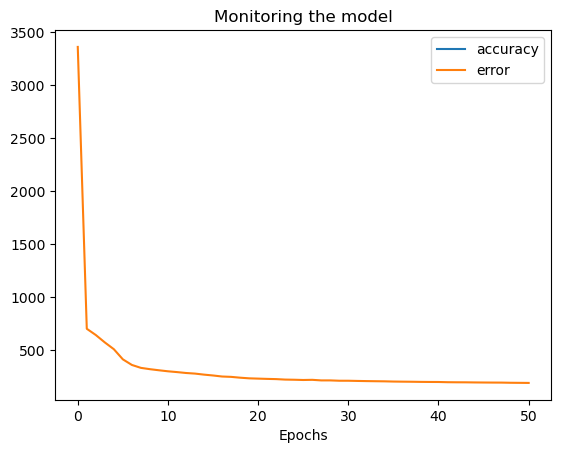

In [117]:
# plt.plot(errors);
plt.plot(acc, label='accuracy');
plt.plot(errors, label='error');
plt.xlabel('Epochs')
plt.title('Monitoring the model')
plt.legend();

> Testing random graphs

In [123]:
G = test_dataset[0]
batch = torch.zeros(G.x.shape[0], dtype=torch.long)
model(G.x, G.edge_index, batch)

tensor([[ 44.8682,  53.5990],
        [ 52.2804,  16.9361],
        [ 26.1853,  34.4112],
        [ 89.7365, 112.2100],
        [ 44.0127,  56.3935],
        [ 34.7122,  35.6345]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [125]:
torch.cat((G.rec_w.unsqueeze(1), G.rec_h.unsqueeze(1)), dim=1)

tensor([[ 38.,  32.],
        [ 47.,  10.],
        [ 27.,  29.],
        [ 88., 120.],
        [ 38.,  74.],
        [ 22.,  30.]], device='cuda:0')